# Bean Disease Prediction for AgroAI  
## Model 5: ResNet50
### Import Dependencies

In [2]:
import tensorflow as tf
from PIL import Image
import cv2, pathlib
from tensorflow.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import os
import shutil
import pickle
import tempfile
from sklearn.model_selection import train_test_split

### Load Images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/FINAL_PROJECT/bean2.zip", 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [5]:
IMAGE_SIZE = 224
TARGET_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
CHANNELS = 3
BATCH_SIZE = 16
INPUT_SHAPE2 = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [6]:
# Set up the base directory
base_dir = "/content/data/train"

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            base_dir,
            labels = 'inferred',
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE,
            color_mode = 'rgb'
)

Found 2970 files belonging to 3 classes.


In [8]:
type(dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [9]:
classes = dataset.class_names
classes

['bean angular leaf spot', 'bean bean rust', 'bean healthy']

In [10]:
len(dataset)

186

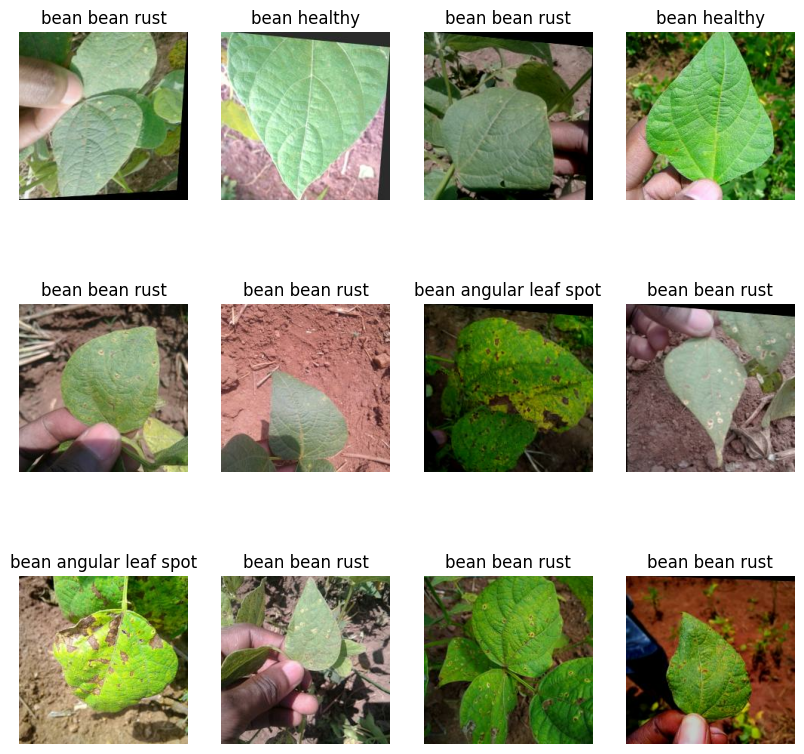

In [11]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [12]:
len(dataset) * 16

2976

### Data Splitting

In [13]:
def data_split(data, train_split = 0.8, val_split = 0.15, 
               test_split = 0.05, shuffle=True, shuffle_size = 10000):
    data_size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size, seed=8)
    
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    
    train_ds = data.take(train_size)
    val_ds = data.skip(train_size).take(val_size)
    test_ds = data.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = data_split(dataset)

In [15]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 148

Length of Validation Dataset is 27

Length of Testing Dataset is 11


### Image Augmentation

In [16]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
type(train_ds)

tensorflow.python.data.ops.take_op._TakeDataset

In [18]:
def resize(ds):
    resizing_rescaling = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Resizing(224,224),
        tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
    ])

    return resizing_rescaling

In [20]:
resizing_rescaling = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224,224),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
])

In [19]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                            interpolation = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

    return data_augmentation

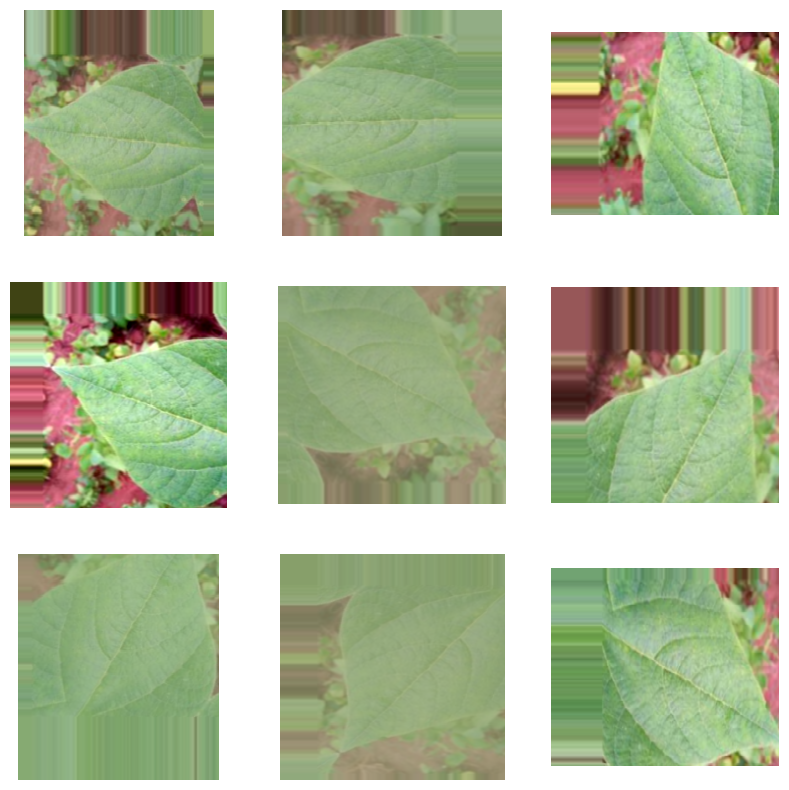

In [20]:
data_augmentation = data_augmenter()

for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [21]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                             width_factor=(-0.3, 0.3),
                                                             fill_mode = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                             width_factor=(-0.3, 0.3),
                                                             fill_mode = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                        interpolation = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

### Init Methods

In [22]:
def conf_matrix(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)

  ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

  ax.set_title('Confusion Matrix with labels\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')
  ax.set_xticks()
  ax.xaxis.set_ticklabels(source_classes, rotation=45)
  ax.yaxis.set_ticklabels(source_classes, rotation=45)

  plt.show()

### Model 5: ResNet50

In [23]:
# Get a single batch from the dataset
batch = next(iter(train_ds))

input_data = batch[0]

# Print the shape of the data in the batch
print(input_data.shape)

(16, 224, 224, 3)


In [24]:
len(classes)

3

In [25]:
from tensorflow.keras.applications.resnet import ResNet50

pre_trained_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

for layer in pre_trained_model.layers[:-15]:
    layer.trainable = False

In [26]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [27]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
#x = data_augmentation(inputs)
#x = preprocess_input(x)
x = preprocess_input(inputs)
#x = data_augmentation(x)
#x = mbnet_v2(x, training=False)
x = pre_trained_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
predict = tf.keras.layers.Dense(3, activation = 'softmax')(x)

model5 = tf.keras.Model(inputs = inputs, outputs = predict)
#model5 = tf.keras.Model(inputs = pre_trained_model.input, outputs = predict)

In [28]:
model5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0     

In [29]:
class EarlyStoppingAtMaxAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True
        elif(logs.get('val_accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True

callbacks = EarlyStoppingAtMaxAccuracy()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

In [30]:
model5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [31]:
history5 = model5.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    callbacks=[callbacks]
)

Epoch 1/100
148/148 [==============================] - 36s 98ms/step - loss: 0.5341 - accuracy: 0.7803 - val_loss: 0.2377 - val_accuracy: 0.8981
Epoch 2/100
148/148 [==============================] - 18s 107ms/step - loss: 0.3114 - accuracy: 0.8798 - val_loss: 0.1399 - val_accuracy: 0.9606
Epoch 3/100
148/148 [==============================] - 14s 81ms/step - loss: 0.1855 - accuracy: 0.9318 - val_loss: 0.0869 - val_accuracy: 0.9722
Epoch 4/100
148/148 [==============================] - 15s 86ms/step - loss: 0.1078 - accuracy: 0.9619 - val_loss: 0.0684 - val_accuracy: 0.9745
Epoch 5/100
148/148 [==============================] - ETA: 0s - loss: 0.1099 - accuracy: 0.9594
Accuracy is high so cancelling training!
148/148 [==============================] - 14s 83ms/step - loss: 0.1099 - accuracy: 0.9594 - val_loss: 0.0334 - val_accuracy: 0.9954


In [32]:
model5.save('Resnet50Model_bean.h5')

In [33]:
score_train = model5.evaluate(train_ds)
score_valid = model5.evaluate(val_ds)
score_test = model5.evaluate(test_ds)

11/11 [==============================] - 4s 57ms/step - loss: 0.0309 - accuracy: 0.9943


In [34]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

In [35]:
print("Accuracy: {}".format(acc[-1]))
print("Validation Accuracy: {}".format(val_acc[-1]))

print("Loss: {}".format(loss[-1]))
print("Validation Loss: {}".format(val_loss[-1]))

Accuracy: 0.9593564867973328
Validation Accuracy: 0.9953703880310059
Loss: 0.10986728966236115
Validation Loss: 0.033423345535993576


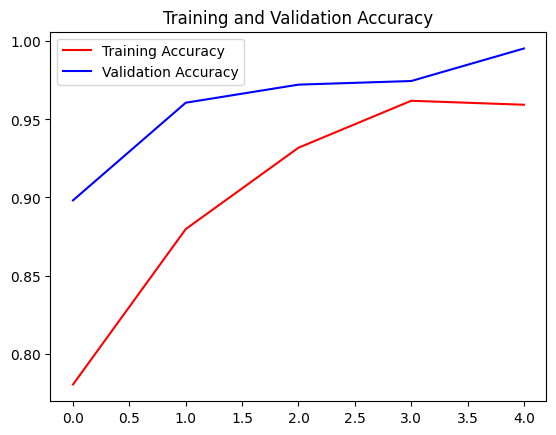

<Figure size 640x480 with 0 Axes>

In [36]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

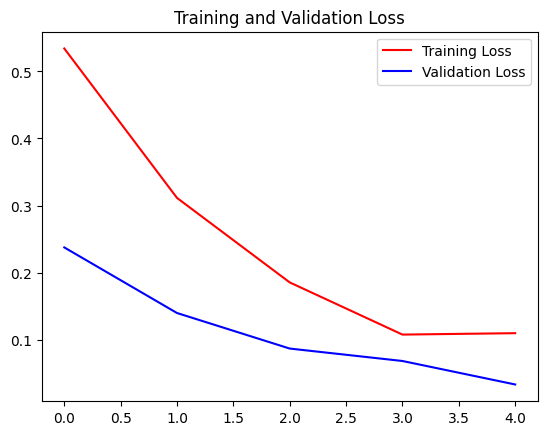

<Figure size 640x480 with 0 Axes>

In [37]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

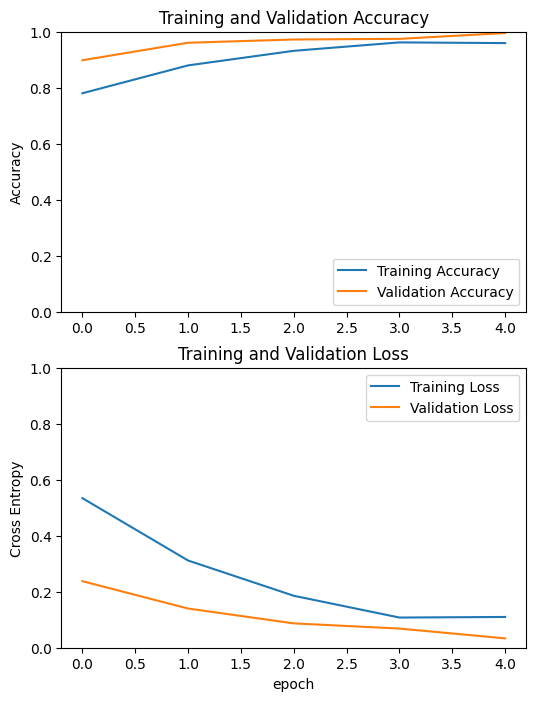

In [38]:
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

first image to predict
actual label: bean healthy
1/1 [==============================] - 1s 1s/step
predicted label: bean healthy


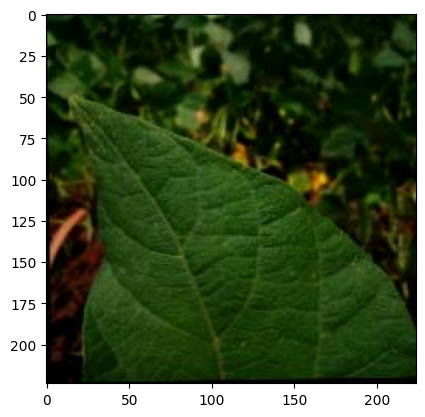

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model5.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [40]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


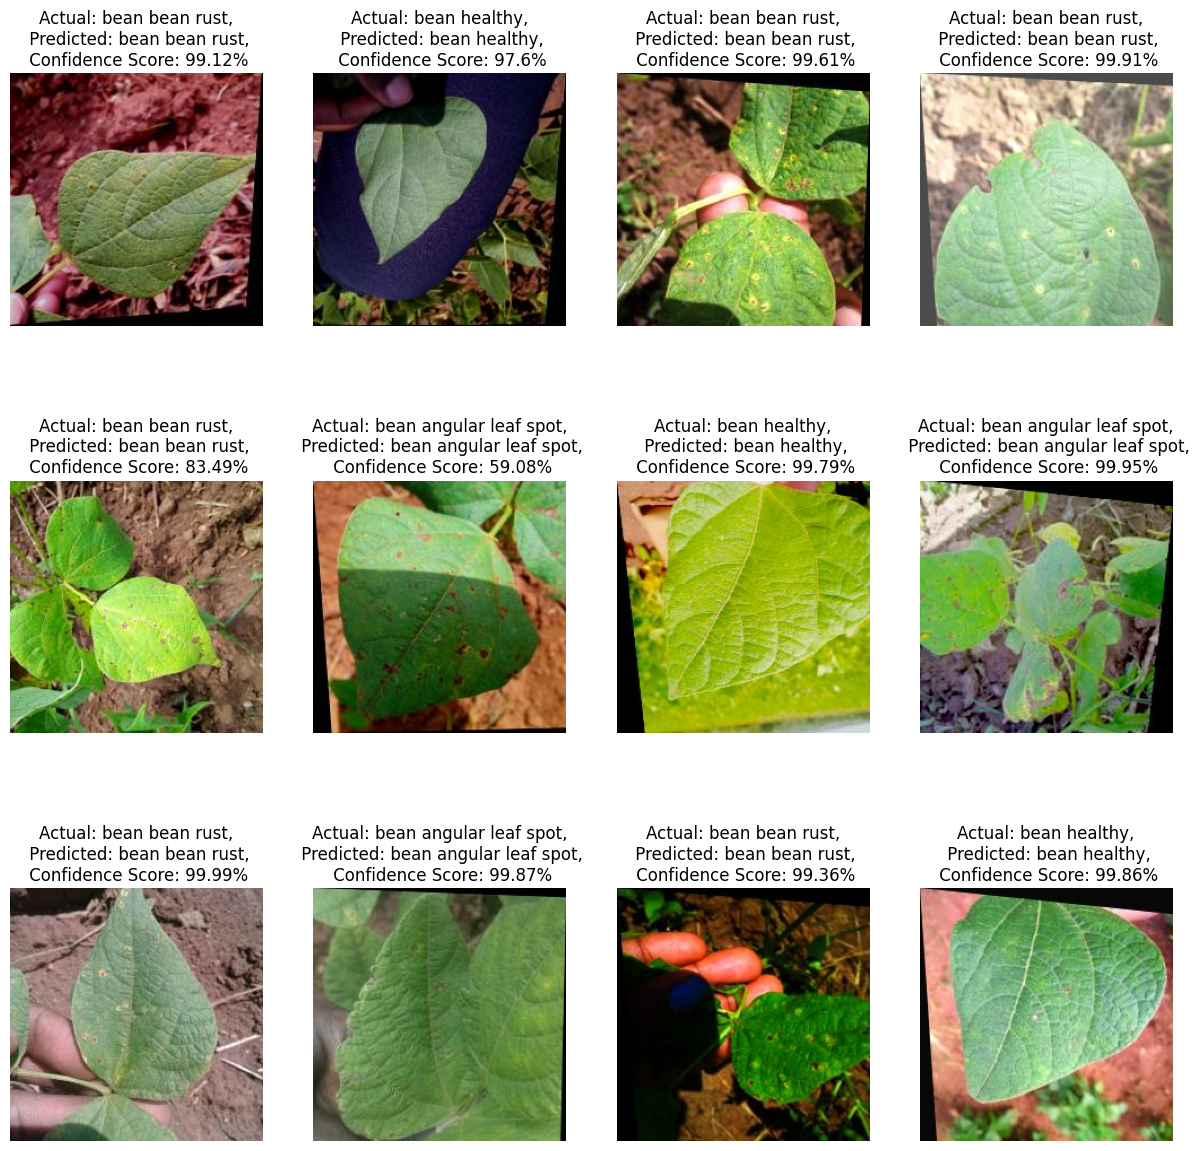

In [41]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model5,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [42]:
pred_class = []
act_class = []
for images,labels in test_ds:
    for i in range(len(test_ds)):
        #ax = plt.subplot(3,4,i+1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model5,images[i].numpy())
        actual_class = classes[labels[i]]

        pred_class.append(predicted_class)
        act_class.append(actual_class)

1/1 [==============================] - 0s 30ms/step


In [43]:
act_class

['bean bean rust',
 'bean angular leaf spot',
 'bean angular leaf spot',
 'bean angular leaf spot',
 'bean healthy',
 'bean healthy',
 'bean healthy',
 'bean angular leaf spot',
 'bean bean rust',
 'bean healthy',
 'bean angular leaf spot',
 'bean healthy',
 'bean healthy',
 'bean healthy',
 'bean bean rust',
 'bean healthy',
 'bean bean rust',
 'bean healthy',
 'bean bean rust',
 'bean bean rust',
 'bean healthy',
 'bean healthy',
 'bean angular leaf spot',
 'bean healthy',
 'bean healthy',
 'bean healthy',
 'bean healthy',
 'bean healthy',
 'bean angular leaf spot',
 'bean bean rust',
 'bean angular leaf spot',
 'bean angular leaf spot',
 'bean angular leaf spot',
 'bean angular leaf spot',
 'bean bean rust',
 'bean bean rust',
 'bean healthy',
 'bean healthy',
 'bean healthy',
 'bean bean rust',
 'bean bean rust',
 'bean bean rust',
 'bean angular leaf spot',
 'bean angular leaf spot',
 'bean bean rust',
 'bean angular leaf spot',
 'bean bean rust',
 'bean healthy',
 'bean bean rust

In [44]:
cm = confusion_matrix(act_class, pred_class, labels=classes)

In [45]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(16,5))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=45)

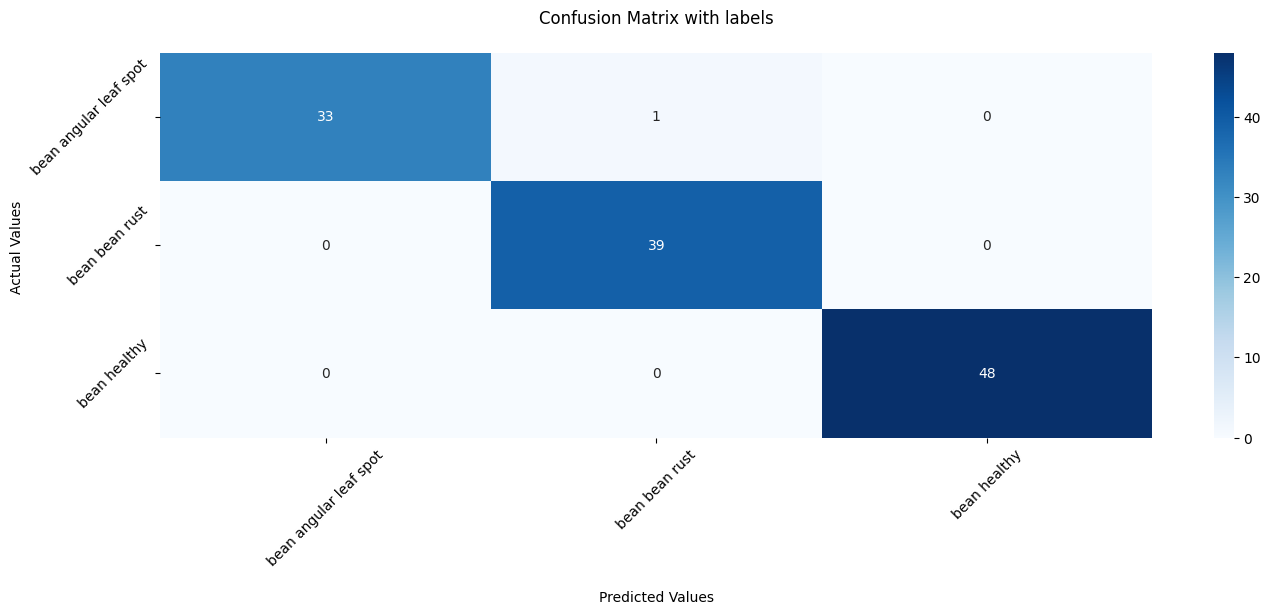

In [46]:
plot_confusion_matrix(cm = cm, classes = classes)

In [47]:
def saved_model(model_path, modelname, model):
  export_path = os.path.join(model_path, modelname)
  model.save(export_path)
  #tf.saved_model.save(model, export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# function to saved_model_history
def saved_model_history(model_path, modelname, history):
  with open(os.path.join(model_path, modelname), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# function to save tflite
def tflite_model_convert(model_path, tflite_path, modelname):

  # Intialize the TFLite converter to load the SavedModel
  export_path = os.path.join(model_path, modelname)

  converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

  # Set the optimization strategy in the converter 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Use the tool to finally convert the model
  tflite_model = converter.convert()

  # Write TFLite model
  tflite_dir = os.path.join(tflite_path, "{}".format(modelname))

  os.mkdir(tflite_dir)

  tflite_file = os.path.join(tflite_dir, "{}.tflite".format(modelname))
  
  label_file = os.path.join(tflite_dir, "{}.txt".format(modelname))

  with open(tflite_file, "wb") as f:
      f.write(tflite_model)

  with open(label_file, 'w') as f:
      f.write('\n'.join(classes))

  print("Export path: ", tflite_dir)
  print(os.listdir(tflite_dir))

In [48]:
model_path = "/content/drive/MyDrive/FINAL_PROJECT/BEAN/RESNET/saved_model"
os.makedirs(model_path, exist_ok=True)
modelname = "ResNet50_bean"
saved_model(model_path, modelname, model5)

Export path:  /content/drive/MyDrive/FINAL_PROJECT/BEAN/RESNET/saved_model/ResNet50_bean
['variables', 'assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb']


In [49]:
model_path = "/content/drive/MyDrive/FINAL_PROJECT/BEAN/RESNET/saved_histori"
os.makedirs(model_path, exist_ok=True)
modelname = "ResNet50_bean"
saved_model_history(model_path, modelname, history5)

In [50]:
# pemanggilan fungsi tflite
model_path = "/content/drive/MyDrive/FINAL_PROJECT/BEAN/RESNET/saved_model"
modelname = "ResNet50_bean"
tflite_path = "/content/drive/MyDrive/FINAL_PROJECT/BEAN/RESNET/saved_tflite"
os.makedirs(tflite_path, exist_ok=True)

tflite_model_convert(model_path, tflite_path, modelname)

Export path:  /content/drive/MyDrive/FINAL_PROJECT/BEAN/RESNET/saved_tflite/ResNet50_bean
['ResNet50_bean.tflite', 'ResNet50_bean.txt']


In [ ]:
model5 = tf.keras.models.load_model('/content/drive/MyDrive/FINAL_PROJECT/POTATO/RESNET/saved_model/ResNet152V2_POTATO')

Saving bean angular1.jpg to bean angular1.jpg
Saving bean angular2.jpg to bean angular2.jpg
Saving bean angular3.jpg to bean angular3.jpg
Saving bean angular5.jpg to bean angular5.jpg
1/1 [==============================] - 0s 28ms/step
predictions :  [[0.92652404 0.07192395 0.00155207]]
predicted label: bean angular leaf spot
1/1 [==============================] - 0s 27ms/step
predictions :  [[9.8443604e-01 1.5192747e-02 3.7117075e-04]]
predicted label: bean angular leaf spot
1/1 [==============================] - 0s 35ms/step
predictions :  [[0.6407778  0.30435786 0.05486434]]
predicted label: bean angular leaf spot
1/1 [==============================] - 0s 24ms/step
predictions :  [[0.91176957 0.08244491 0.0057855 ]]
predicted label: bean angular leaf spot


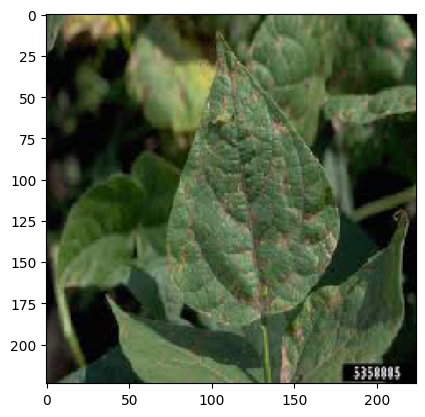

In [51]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model5.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])

Saving bean rust.jpg to bean rust.jpg
Saving bean rust2.jpg to bean rust2.jpg
Saving bean rust3.jpg to bean rust3.jpg
Saving bean rust4.jpg to bean rust4.jpg
1/1 [==============================] - 0s 25ms/step
predictions :  [[9.9758446e-01 1.9524472e-03 4.6307888e-04]]
predicted label: bean angular leaf spot
1/1 [==============================] - 0s 24ms/step
predictions :  [[1.4174627e-03 9.9858022e-01 2.3613711e-06]]
predicted label: bean bean rust
1/1 [==============================] - 0s 25ms/step
predictions :  [[9.9999225e-01 7.7254199e-06 1.5423236e-08]]
predicted label: bean angular leaf spot
1/1 [==============================] - 0s 28ms/step
predictions :  [[5.2069187e-02 9.4783831e-01 9.2591334e-05]]
predicted label: bean bean rust


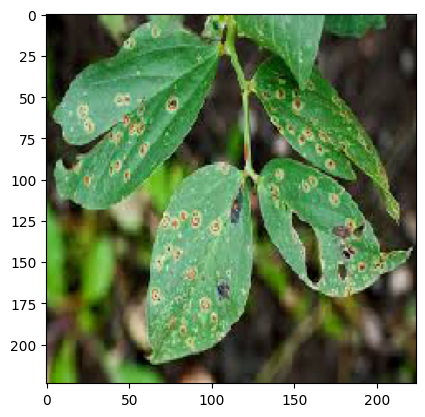

In [52]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for image in uploaded.keys():
  img = load_img(image, target_size=(224, 224))
  imgplot = plt.imshow(img)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model5.predict(img_array)
  print("predictions : " ,predictions)
  print("predicted label:",classes[np.argmax(predictions)])